
# 04 — Model Comparison & Evaluation (JSON → Table → Charts)

This notebook imports three JSON files with evaluation metrics, **extracts key metrics** (Accuracy, Macro F1, Weighted F1), **builds a comparison table**, and **plots bar charts**.

**Files expected:**
- `Majority_classifier.json`
- `TF_IDF_Classifier.json`
- `DistilBERT_classifier.json`


In [1]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\David\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 1) Imports and setup

In [2]:

import os, json
import pandas as pd
import matplotlib.pyplot as plt

# Ensure plots display nicely
%matplotlib inline

# For consistent decimal formatting in printouts
pd.options.display.float_format = '{:.4f}'.format
print("✅ Libraries imported.")



✅ Libraries imported.


## 2) Load JSON files

In [3]:

# Candidate locations to search (edit to your repo structure)
CANDIDATE_PATHS = [
    ".",                 # current directory
    "artifacts",         # common artifacts folder
    "/mnt/data"          # sandbox path (if running in this environment)
]

FILENAMES = {
    "Majority": "Majority_classifier.json",
    "TF-IDF": "TF_IDF_Classifier.json",
    "DistilBERT": "DistilBERT_classifier.json",
}

def find_file(name):
    for base in CANDIDATE_PATHS:
        p = os.path.join(base, name)
        if os.path.exists(p):
            return p
    return None

loaded = {}
missing = []

for label, fname in FILENAMES.items():
    p = find_file(fname)
    if p is None:
        missing.append(fname)
    else:
        with open(p, "r") as f:
            try:
                loaded[label] = json.load(f)
            except json.JSONDecodeError as e:
                print(f"❌ JSON decode error for {fname}: {e}")
                raise

if missing:
    print("⚠️ Missing files:", missing)
else:
    print("✅ Loaded all JSON files.")
loaded.keys()


✅ Loaded all JSON files.


dict_keys(['Majority', 'TF-IDF', 'DistilBERT'])

## 3) Extract and organize metrics

In [4]:

def extract_metrics(model_name, obj):
    """Robustly extract Accuracy, Macro F1, Weighted F1 from different JSON layouts."""
    acc = None
    f1_macro = None
    f1_weighted = None
    per_class = {}
    notes = None
    
    # Some files store 'dataset' at top, others have 'validation'/'test' sections.
    # Try DistilBERT-style
    if isinstance(obj, dict):
        # DistilBERT flat style (example keys: accuracy, f1_weighted, classification_report)
        acc = obj.get("accuracy", acc)
        f1_weighted = obj.get("f1_weighted", obj.get("weighted_f1", f1_weighted))
        # Macro F1 may exist as macro_avg.f1_score or macro_avg dict inside classification_report
        cr = obj.get("classification_report")
        if isinstance(cr, dict):
            macro = cr.get("macro_avg") or cr.get("macro average") or {}
            if isinstance(macro, dict):
                f1_macro = macro.get("f1_score", f1_macro)
            # per-class block
            for k,v in cr.items():
                if isinstance(v, dict) and {"precision","recall","f1_score"} <= set(v.keys()):
                    per_class[k] = v.get("f1_score")
        
        # Some store warnings/notes
        if "notes" in obj:
            notes = obj["notes"]
        
        # Majority baseline style
        if "classification_report" in obj and acc is None:
            acc = obj.get("accuracy", acc)
            wa = obj["classification_report"].get("weighted_avg", {})
            if isinstance(wa, dict):
                f1_weighted = wa.get("f1_score", f1_weighted)
            ma = obj["classification_report"].get("macro_avg", {})
            if isinstance(ma, dict):
                f1_macro = ma.get("f1_score", f1_macro)
            # per-class already captured above
        
        # TF-IDF style nested under test/validation
        if "test" in obj or "validation" in obj:
            # Prefer test set if present
            split = obj.get("test") or obj.get("validation") or {}
            acc = split.get("accuracy", acc)
            wa = split.get("weighted_avg", {})
            if isinstance(wa, dict):
                f1_weighted = wa.get("f1_score", f1_weighted)
            ma = split.get("macro_avg", {})
            if isinstance(ma, dict):
                f1_macro = ma.get("f1_score", f1_macro)
            per_class = {}
            pc = split.get("per_class", {})
            if isinstance(pc, dict):
                for k,v in pc.items():
                    if isinstance(v, dict):
                        per_class[k] = v.get("f1_score")
    
    return {
        "Model": model_name,
        "Accuracy": acc,
        "Macro F1": f1_macro,
        "Weighted F1": f1_weighted,
        "Per-class F1": per_class or None,
        "Notes": notes
    }

rows = []
for name, obj in loaded.items():
    rows.append(extract_metrics(name, obj))

summary_df = pd.DataFrame(rows)
summary_df


,Model,Accuracy,Macro F1,Weighted F1,Per-class F1,Notes
0,Majority,0.2632,0.1000,0.1096,"{'account': 0.0, 'billing': 0.0, 'other': 0.42...",None
1,TF-IDF,0.7400,0.7100,0.7100,"{'account': 0.74, 'billing': 0.82, 'other': 0....",None
2,DistilBERT,1.0000,1.0000,1.0000,"{'account': 1.0, 'billing': 1.0, 'other': 1.0,...",No misclassified samples found in the test set...


## 4) Build comparison table 

In [5]:

display_cols = ["Model", "Accuracy", "Weighted F1", "Macro F1"]
cmp_df = summary_df[display_cols].copy()

# Ensure numeric
for c in ["Accuracy", "Weighted F1", "Macro F1"]:
    cmp_df[c] = pd.to_numeric(cmp_df[c], errors="coerce")

cmp_df.sort_values(by="Weighted F1", ascending=False, inplace=True)
cmp_df.reset_index(drop=True, inplace=True)
cmp_df


,Model,Accuracy,Weighted F1,Macro F1
0,DistilBERT,1.0000,1.0000,1.0000
1,TF-IDF,0.7400,0.7100,0.7100
2,Majority,0.2632,0.1096,0.1000


## 5) Plot bar charts (Accuracy & Weighted F1)

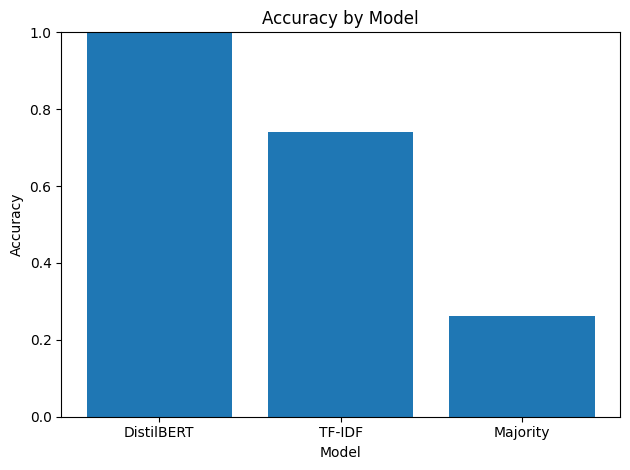

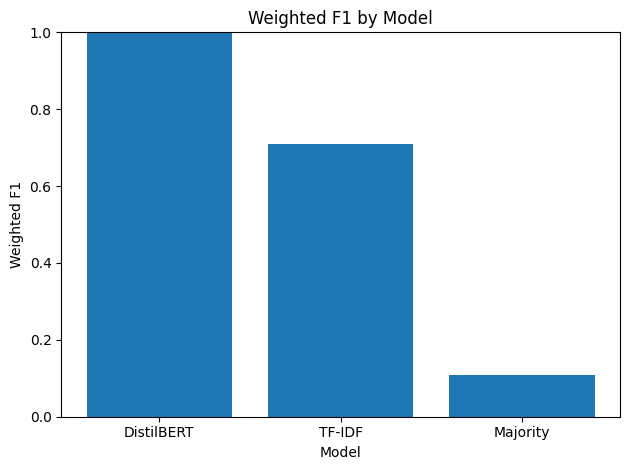

In [6]:

# Accuracy
plt.figure()
plt.bar(cmp_df["Model"], cmp_df["Accuracy"])
plt.title("Accuracy by Model")
plt.ylim(0, 1.0)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# Weighted F1
plt.figure()
plt.bar(cmp_df["Model"], cmp_df["Weighted F1"])
plt.title("Weighted F1 by Model")
plt.ylim(0, 1.0)
plt.xlabel("Model")
plt.ylabel("Weighted F1")
plt.tight_layout()
plt.show()


## 6)  Per-class F1 breakdown (text view)

In [7]:

for _, row in summary_df.iterrows():
    print("\n=== Per-class (F1) —", row["Model"], "===")
    pc = row["Per-class F1"]
    if isinstance(pc, dict) and pc:
        temp = pd.DataFrame([pc]).T
        temp.columns = ["F1"]
        display(temp.sort_index())
    else:
        print("(no per-class details found in JSON)")



=== Per-class (F1) — Majority ===


,F1
account,0.0000
billing,0.0000
macro_avg,0.1000
other,0.4200
technical,0.0000
weighted_avg,0.1100



=== Per-class (F1) — TF-IDF ===


,F1
account,0.7400
billing,0.8200
other,0.8200
technical,0.4500



=== Per-class (F1) — DistilBERT ===


,F1
account,1.0000
billing,1.0000
macro_avg,1.0000
other,1.0000
technical,1.0000
weighted_avg,1.0000
